### TUGAS 1 DEEP LEARNING - Tsania Az Zahra - 05111940000032
##### KESIMPULAN


##### Analisis Sentimen Tweet dengan LSTM

###### 1. Akurasi dan Loss training dari LSTM didapatkan 98,5% dan 4,8%
###### 2. Akurasi dan Loss testing dari LSTM didapatkan 79,6% dan 105% : masih banyak didapatkan kegagalan model dalam membaca atau memprediksi data test. banyaknya loss lebih dari 50% menjamin bahwa kesalahan prediksi sangat memungkinkan untuk terjadi. (model overfit)
###### 3. 1 dari 3 prediksi kalimat dengan model LSTM adalah sesuai/benar

##### Analisis Sentimen Tweet dengan RNN

###### 1. Akurasi dan Loss training dari RNN didapatkan 97,9% dan 6,6%
###### 2. Akurasi dan Loss testing dari RNN didapatkan 75,9% dan 96,3% : masih banyak didapatkan kegagalan model dalam membaca atau memprediksi data test. banyaknya loss lebih dari 50% menjamin bahwa kesalahan prediksi sangat memungkinkan untuk terjadi. (model overfit)
###### 3. 1 dari 3 prediksi kalimat dengan model RNN adalah sesuai/benar

##### Catatan :

###### - belum ditambahkan visualisasi grafik sehingga gap test dan train belum bisa diperlihatkan
###### - robust tidaknya model bisa jadi dipengaruhi oleh teknik preproses dan vektorisasi dataset

### IMPORT LIBRARY

###### Inisiasi library yang digunakan sepanjang proses klasifikasi hingga prediksi.


In [142]:
import tensorflow as tf
from keras.models import Sequential
from keras import regularizers, models, layers, optimizers, losses, metrics
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from nltk.tokenize import  word_tokenize
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.utils.data_utils import pad_sequences 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib as plt
import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report

### MENGENALI DATA

###### Analisis karakteristik data


In [143]:
COLUMNS = ['TWEET_TEXT', 'EMOTION_IN_TWEET_IS_DIRECTED_AT','IS_DIRECTED_AT_A_BRAND_OR_PRODUCT']
#STANDARD = "ISO-8859-1"
# spam = pd.read_csv('./dataset.csv',encoding=STANDARD , header=0)
spam = pd.read_csv('./dataset.csv',header=0)

spam.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [144]:
spam.describe

<bound method NDFrame.describe of                                              tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  �ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mentio...   

     emotion_in_tweet_is_directed_at  \
0                             iPhone   
1                 iPad or iPhone App   
2                               iPad   
3                 iPad or iPhone App   
4                             Google   
...              

In [145]:
spam.groupby(['is_there_an_emotion_directed_at_a_brand_or_product']).size().reset_index(name='count')

,is_there_an_emotion_directed_at_a_brand_or_product,count
0,I can't tell,156
1,Negative emotion,570
2,No emotion toward brand or product,5389
3,Positive emotion,2978


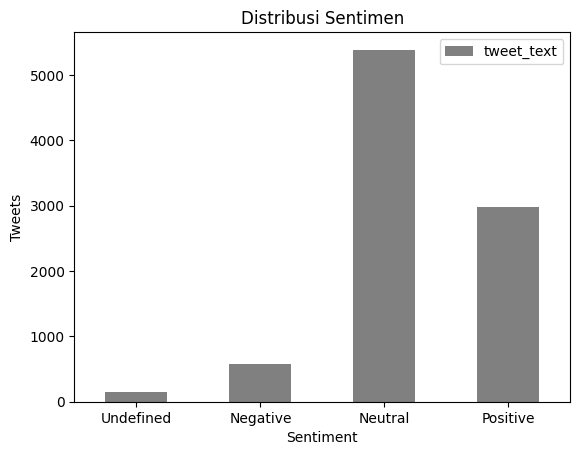

In [146]:
# Ambil data yang dibutuhkan saja
labels = ["Undefined","Negative","Neutral","Positive"]
spam = spam[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]
ax = spam.groupby('is_there_an_emotion_directed_at_a_brand_or_product').count().plot(kind='bar', color='grey', title='Distribusi Sentimen',legend=True)
ax.set_xticklabels(labels=labels,rotation=0)
ax.set_xlabel("Sentiment")
ax.set_ylabel("Tweets")

# Simpan data dalam list
sentiment, tweet = list(spam['is_there_an_emotion_directed_at_a_brand_or_product']), list(spam['tweet_text'])

### PREPROCESSING DATASET

###### Untuk menyederhanakan dataset dengan hanya mendapatkan informasi penting dari tweet maka diperlukan adanya teks preprocessing. Beberapa teknik di antaranya adalah :

###### 1. mendefinisikan feeling dari tweet melalui emoji : dengan harapan dapat memberi kecenderungan terhadap sentimen positif atau negatif

###### 2. mengubah menjadi lowercase : singkatan tidak dibutuhkan dan cenderung membentuk kata yang tidak jelas rendah kesamaannya dengan kosakata pada umumnya

###### 3. uniformisasi username : kita tidak perlu mengetahui siapa yang mengirim atau terlibat dalam tweet

###### 4. menghapus kata-kata pendek kurang dari 2 huruf : memperbanyak cost untuk encoding dan pengaruhnya tidak begitu signifikan

###### 5. mengganti semua karakter non-alphabet dengan null-string value.


In [147]:
### Definisikan EMOJI : buat mapping untuk replace text
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [148]:
# spam = spam[spam["is_there_an_emotion_directed_at_a_brand_or_product"] != "NaN"]
# Regex untuk string replacement
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
sxswPattern       = '(?<!\w)#[A-Z]\S{1,49}(?!\w)'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

spam = spam[spam["is_there_an_emotion_directed_at_a_brand_or_product"] != "No emotion toward brand or product"]
spam['tweet_text'] = spam['tweet_text'].apply(lambda x: x.lower()) ## konversi seluruh karakter ke lowercase
spam['tweet_text'] = spam['tweet_text'].apply((lambda x: re.sub(alphaPattern, " ", x))) ## hilangkan semua selain alfabet
spam['tweet_text'] = spam['tweet_text'].apply((lambda x: re.sub( urlPattern,' URL',x))) ## seragamkan semua url dengan string URL
spam['tweet_text'] = spam['tweet_text'].apply((lambda x: re.sub(userPattern,' USER', x))) ## seragamkan semua username dengan string USER
spam['tweet_text'] = spam['tweet_text'].apply((lambda x: re.sub(sequencePattern, seqReplacePattern, x))) ## perpendek kata yang memiliki huruf berlebih dari kosakata aslinya
spam['tweet_text'] = spam['tweet_text'].apply((lambda x: re.sub(sxswPattern, " ", x))) ## abaikan hashtag
for emoji in emojis.keys():
    spam['tweet_text'] = spam['tweet_text'].replace(emoji, "EMOJI" + emojis[emoji])

print(spam['tweet_text'])

for idx,row in spam.iterrows():
    row[0] = row[0].replace('rt',' ')

0         wesley83 i have a 3g iphone  after 3 hrs twe...
1        jessedee know about  fludapp  awesome ipad ip...
2        swonderlin can not wait for  ipad 2 also  the...
3        sxsw i hope this year s festival isn t as cra...
4        sxtxstate great stuff on fri  sxsw  marissa m...
                              ...                        
9077     mention your pr guy just convinced me to swit...
9079     quot papyrus  sort of like the ipad quot  nic...
9080    diller says google tv  quot might be run over ...
9085    i ve always used camera  for my iphone b c it ...
9088                         ipad everywhere  sxsw  link 
Name: tweet_text, Length: 3704, dtype: object


### Visualisasi dengan WordCloud

###### menampilkan kata terbanyak muncul dengan sentimen negatif atau positif.


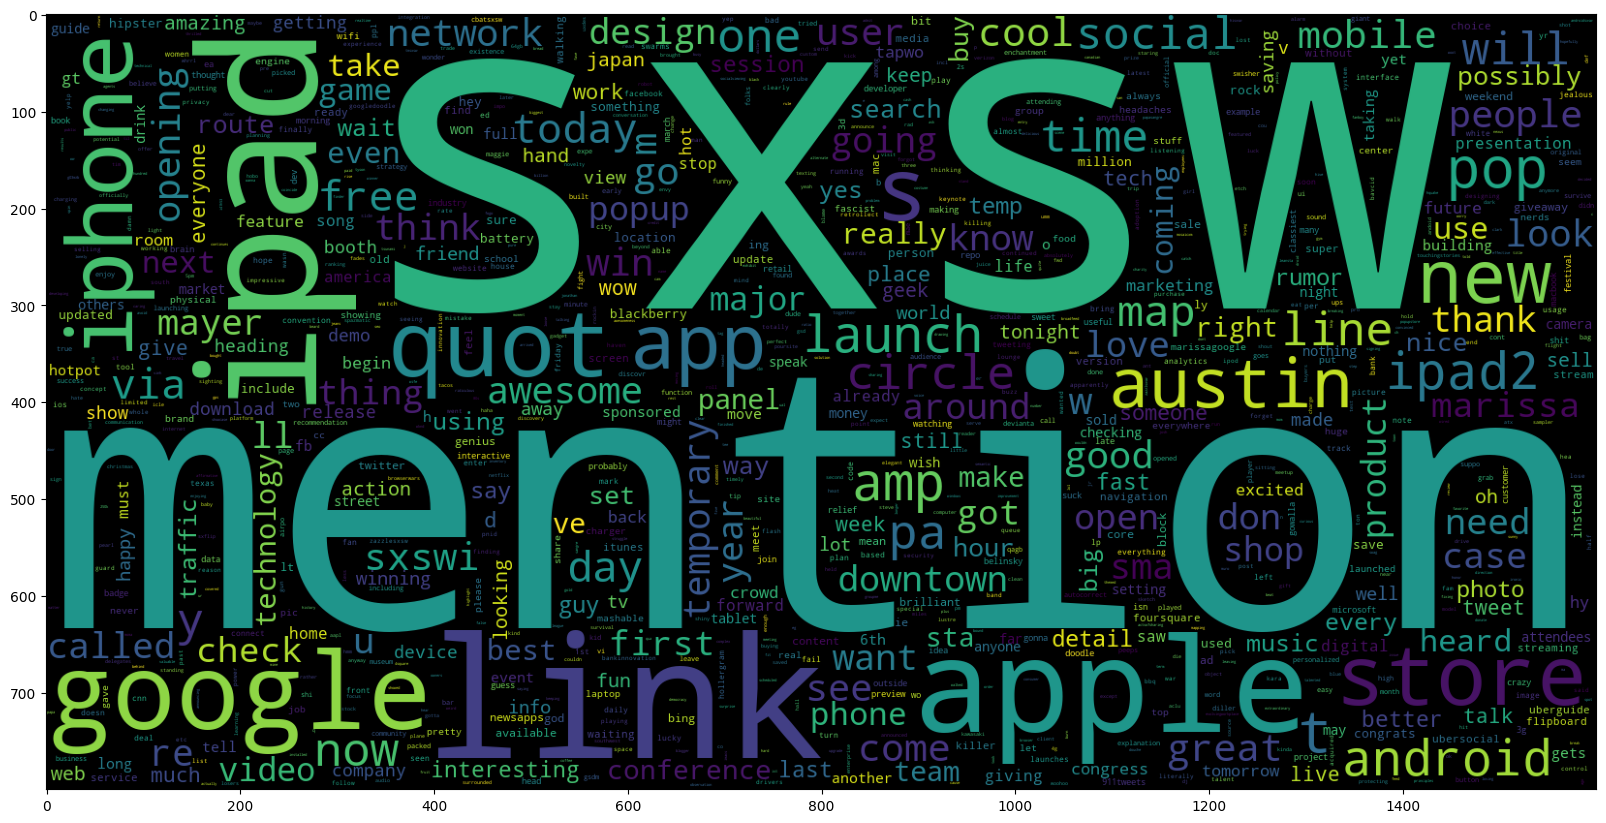

In [149]:
pos_sentiment = spam['tweet_text'][2000:]
plt.figure(figsize = (20,20))
pos = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(pos_sentiment))
plt.imshow(pos)

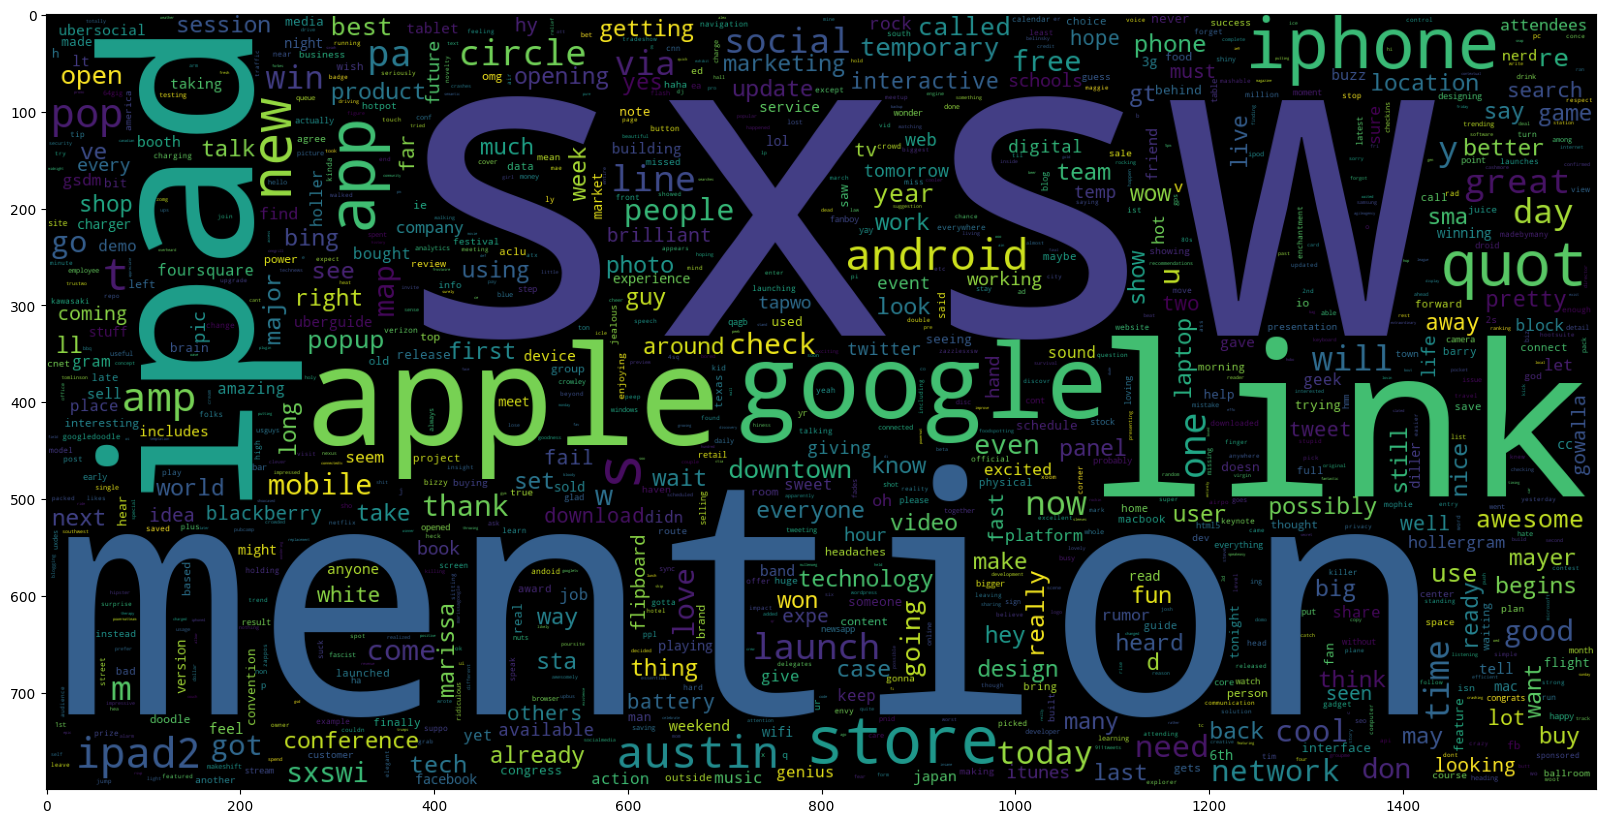

In [150]:
neg_sentiment = spam['tweet_text'][:2000]
plt.figure(figsize = (20,20))
neg = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(neg_sentiment))
plt.imshow(neg)

### Konversi Teks ke Vektor Numerik

###### teks dijadikan vektor yang dapat di-digest oleh deep learning model


In [151]:
max_features = 2000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
maxlen = 4
batch_size = 32
nb_classes = 4

In [152]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(spam['tweet_text'].values)
X = tokenizer.texts_to_sequences(spam['tweet_text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(spam["is_there_an_emotion_directed_at_a_brand_or_product"]).values

In [153]:
Y

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [154]:
X.shape
print(X)

[[   0    0    0 ... 1340    7    1]
 [   0    0    0 ...   76    7    1]
 [   0    0    0 ...  210    7    1]
 ...
 [   0    0    0 ...   18    1  421]
 [   0    0    0 ...  551    1   90]
 [   0    0    0 ...  497    1    5]]


In [155]:
Y.shape
print(Y)

[[0 1 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 1 0]
 [0 0 1]
 [0 0 1]]


### Buat Model Klasifikasi

###### Untuk pembuatan model klasifikasi akan digunakan LSTM dan RNN


In [156]:
embed_dim = 256
lstm_out = 256

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 33, 256)           512000    
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,038,083
Trainable params: 1,038,083
Non-trainable params: 0
_________________________________________________________________
None


In [157]:
X.shape


(3704, 33)

In [158]:
Y.shape

(3704, 3)

### Konfigurasi Data Test dan Data Train

###### Split data menjadi 2 bagian. Karena jumlah data adalah kurang lebih 9000 maka digunakan perbandingan test:train dengan 2:8


In [159]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2963, 33) (2963, 3)
(741, 33) (741, 3)


### LSTM

In [160]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
93/93 - 20s - loss: 0.5993 - accuracy: 0.7992 - 20s/epoch - 214ms/step
Epoch 2/10
93/93 - 17s - loss: 0.4091 - accuracy: 0.8562 - 17s/epoch - 181ms/step
Epoch 3/10
93/93 - 16s - loss: 0.2914 - accuracy: 0.8873 - 16s/epoch - 177ms/step
Epoch 4/10
93/93 - 17s - loss: 0.2203 - accuracy: 0.9207 - 17s/epoch - 188ms/step
Epoch 5/10
93/93 - 17s - loss: 0.1499 - accuracy: 0.9494 - 17s/epoch - 182ms/step
Epoch 6/10
93/93 - 17s - loss: 0.1160 - accuracy: 0.9595 - 17s/epoch - 183ms/step
Epoch 7/10
93/93 - 16s - loss: 0.0809 - accuracy: 0.9747 - 16s/epoch - 177ms/step
Epoch 8/10
93/93 - 17s - loss: 0.0679 - accuracy: 0.9774 - 17s/epoch - 178ms/step
Epoch 9/10
93/93 - 17s - loss: 0.0567 - accuracy: 0.9814 - 17s/epoch - 183ms/step
Epoch 10/10
93/93 - 16s - loss: 0.0484 - accuracy: 0.9852 - 16s/epoch - 171ms/step


### Evaluasi Model LSTM

###### Mendapatkan akurasi dari data test

In [161]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

test loss and accuracy: 1.0522136688232422 0.7962213158607483


### Prediksi Dengan Model

###### Melakukan prediksi dengan defined string bebas

In [162]:
def predict(model,txt):
    #vektorisasi string agar digestable oleh mesin
    txt = tokenizer.texts_to_sequences(txt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    txt = pad_sequences(txt, maxlen=33, dtype='int32', value=0)
    #print(txt)
    sentiment = model.predict(txt,batch_size=1,verbose = 2)[0]
    if(np.argmax(sentiment) == 1):
        #print("Positive" + str(np.argmax(sentiment)))
        print("Positive")
    elif (np.argmax(sentiment) == 0):
        #print("Negative" + str(np.argmax(sentiment)))
        print("Negative")
    else:
        #print("Neutral" + str(np.argmax(sentiment)))
        print("Neutral")

In [163]:
predict(model,'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB')

### Seharusnya Positive

129/129 - 1s - 1s/epoch - 11ms/step
Positive


In [164]:
predict(model,"Navigating a crowded party sucks. But its way worse when everyone walks around with their face in their iPhone. #sxsw #adpeopleproblems")

### Seharusnya Negative

135/135 - 1s - 904ms/epoch - 7ms/step
Neutral


In [165]:
predict(model,"Apple's pop up store in Austin just took shape this week. Now that's what I call a pop-up. #sxsw")

### Seharusnya Neutral

96/96 - 1s - 588ms/epoch - 6ms/step
Negative


### RNN

In [166]:
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add((SimpleRNN(256)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 33, 256)           512000    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 3)                 771       
                                                                 
Total params: 644,099
Trainable params: 644,099
Non-trainable params: 0
_________________________________________________________________
None


In [167]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
93/93 - 6s - loss: 0.6280 - accuracy: 0.7962 - 6s/epoch - 60ms/step
Epoch 2/10
93/93 - 4s - loss: 0.5217 - accuracy: 0.8097 - 4s/epoch - 43ms/step
Epoch 3/10
93/93 - 4s - loss: 0.3130 - accuracy: 0.8917 - 4s/epoch - 46ms/step
Epoch 4/10
93/93 - 4s - loss: 0.1738 - accuracy: 0.9460 - 4s/epoch - 46ms/step
Epoch 5/10
93/93 - 5s - loss: 0.1300 - accuracy: 0.9625 - 5s/epoch - 48ms/step
Epoch 6/10
93/93 - 4s - loss: 0.0966 - accuracy: 0.9690 - 4s/epoch - 44ms/step
Epoch 7/10
93/93 - 4s - loss: 0.0874 - accuracy: 0.9754 - 4s/epoch - 43ms/step
Epoch 8/10
93/93 - 4s - loss: 0.0699 - accuracy: 0.9828 - 4s/epoch - 42ms/step
Epoch 9/10
93/93 - 5s - loss: 0.0726 - accuracy: 0.9787 - 5s/epoch - 49ms/step
Epoch 10/10
93/93 - 5s - loss: 0.0662 - accuracy: 0.9798 - 5s/epoch - 58ms/step


### Evaluasi Model RNN

###### Mendapatkan akurasi dari data test

In [168]:
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

test loss and accuracy: 0.9632474184036255 0.7597841024398804


In [169]:
predict(model,'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB')

### Seharusnya Positive

129/129 - 1s - 1s/epoch - 9ms/step
Neutral


In [170]:
predict(model,"Navigating a crowded party sucks. But its way worse when everyone walks around with their face in their iPhone. #sxsw #adpeopleproblems")

### Seharusnya Negative

135/135 - 1s - 743ms/epoch - 6ms/step
Neutral


In [171]:
predict(model,"Apple's pop up store in Austin just took shape this week. Now that's what I call a pop-up. #sxsw")

### Seharusnya Neutral

96/96 - 0s - 458ms/epoch - 5ms/step
Neutral
